In [1]:
!pip install feature-engine lightgbm xgboost catboost==0.25.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 276 kB 5.0 MB/s 
     |████████████████████████████████| 67.3 MB 14 kB/s 


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from feature_engine.imputation import ArbitraryNumberImputer, MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.model_selection import GridSearchCV

# Reading ABT

In [4]:
# Read Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Read abt

df = pd.read_csv('/content/drive/My Drive/TCC_FIA_IA/base_abt_modelagem.csv', index_col=0)
df

,Item,venfis,venfin,itens,itens_dist,datas,estoque,recencia,revendeu_prox_mes,ref_prev
0,-,3,127.50,1,1,28.0,0.0,156,0,2021-09-01
1,11ER030M D=3,3,27.52,1,1,28.0,0.0,113,0,2021-09-01
2,11ER040M D=4,10,27.52,1,1,28.0,0.0,113,0,2021-09-01
3,11ER060M D=6,10,27.52,1,1,28.0,0.0,113,0,2021-09-01
4,11IRAG60 (RT11 01NA60 YBG205),10,44.82,1,1,28.0,0.0,6,0,2021-09-01
...,...,...,...,...,...,...,...,...,...,...
2648,XNGU100408ERML WU10PM,10,40.00,1,1,28.0,0.0,180,0,2022-02-01
2649,XNGU100408ERML WU10PM,20,46.62,1,1,35.0,20.0,267,0,2022-02-01
2650,XNGU100408ERML WU10PM,10,29.43,1,1,28.0,40.0,316,0,2022-02-01
2651,XNGU15T608ERALP WN25PM,10,125.00,1,1,35.0,0.0,313,0,2022-02-01


# Rename variables

In [6]:
# Rename variables

key_vars = ['ref_prev', 'Item']

num_vars = ['venfis', 'venfin', 'itens', 'itens_dist', 'datas', 'estoque', 'recencia']

target = 'revendeu_prox_mes'

cat_vars = []

features = num_vars+cat_vars

In [7]:
X = df[features]
y = df[target]

# Apply a RandomForestModel

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size=0.8, 
                                                    stratify= y, 
                                                    random_state=42)

In [ ]:
rf = RandomForestClassifier(random_state = 42, max_depth = 4)
rf.fit(X_train, y_train)

In [ ]:
acc_train = accuracy_score(y_train, rf.predict(X_train))
acc_test = accuracy_score(y_test, rf.predict(X_test))
print(f'A Acuracia da base de treino é de {acc_train*100:.3f} e a da base de teste é de {acc_test*100:.3f}')

# Apply other algorithms

In [ ]:
random_state = 42

modelos_lineares = [
    ('logistic_regression', LogisticRegression(random_state = random_state)),
    ('svm', SVC(random_state = random_state, probability=True))
]

steps_modelos_lineares = [
    ('numeric_scaler', SklearnTransformerWrapper(variables = num_vars, transformer = StandardScaler())), 
    ]

steps_modelos_arvores = []

modelos_arvores = [
    ('decision_tree', DecisionTreeClassifier(random_state=random_state)),
    ('random_forest', RandomForestClassifier(random_state=random_state)),
    ('gb', GradientBoostingClassifier(random_state=random_state)),
    ('xgb', XGBClassifier(random_state=random_state)),
    ('lgbm', LGBMClassifier(random_state=random_state)),
    ('catboost', CatBoostClassifier(random_state=random_state))
]


In [ ]:
# Dataframe with main metrics
df_resultados = pd.DataFrame(columns=['acuracidade_train', 'precision_train', 'recall_train', 'f1_train', 'roc_auc_train',
                                      'acuracidade_test', 'precision_test', 'recall_test', 'f1_test', 'roc_auc_test'])
df_resultados

In [ ]:
# Function to automatizate
def rodar_modelos(modelo, steps, X_train, y_train, X_test, y_test ,random_state , n_splits = 5 , n_jobs = -1):
    pipeline = Pipeline(steps = steps + [modelo])
    skf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state = random_state)
    resultado_cv = cross_validate(estimator = pipeline,
                                  X = X_train,
                                  y = y_train,
                                  scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                                  cv = skf,
                                  n_jobs = n_jobs)
    

    modelo = pipeline.fit(X_train, y_train)
    y_pred_prob = modelo.predict_proba(X_test)[:,1]
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precisao = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred_prob)


    df_aux = pd.DataFrame(resultado_cv)
    dfar = df_aux.mean()



    return [
            dfar.loc['test_accuracy'], 
            dfar.loc['test_precision'], 
            dfar.loc['test_recall'], 
            dfar.loc['test_f1'], 
            dfar.loc['test_roc_auc'],
            acc,
            precisao,
            recall,
            f1,
            roc
    ]
    

In [ ]:
for i in modelos_lineares:
    print(f'Rodando o modelo {i[0]}')
    var = rodar_modelos(modelo = i, 
                       steps = steps_modelos_lineares, 
                       X_train = X_train, 
                       y_train = y_train,
                       X_test = X_test,
                       y_test = y_test,
                       random_state = 42,
                       n_splits = 5,
                       n_jobs = -1)
    df_resultados.loc[i[0]] = var

for i in modelos_arvores:
    print(f'Rodando o modelo {i[0]}')
    var = rodar_modelos(modelo = i,
                       steps =  steps_modelos_arvores,
                       X_train = X_train, 
                       y_train = y_train, 
                       X_test = X_test,
                       y_test = y_test,
                       random_state = 42,
                       n_splits = 5,
                       n_jobs = -1)
    df_resultados.loc[i[0]] = var


In [ ]:
df_resultados.sort_values(by = 'roc_auc_test', ascending = False)

Usando 5 meses na ABT para prever o sexto mês, os modelos ficaram mto ruins para recall e precision

# Using Imbalanced Sklearn

In [9]:
df.revendeu_prox_mes.value_counts(normalize = True)

0    0.825519
1    0.174481
Name: revendeu_prox_mes, dtype: float64

In [10]:
df.revendeu_prox_mes.value_counts()

0    10811
1     2285
Name: revendeu_prox_mes, dtype: int64

In [11]:
metrics_neigh = pd.DataFrame(columns = ['precisao', 'recall', 'acc', 'iterador'])
prec_neigh = []
recall_neigh = []
acc_neigh = []
iterador = []
for i in range(1, 30):
    neigh = KNeighborsClassifier(n_neighbors = i)
    neigh.fit(X_train, y_train)
    y_pred_neigh = neigh.predict(X_test)
    prec_neigh.append(precision_score(y_test, y_pred_neigh))
    recall_neigh.append(recall_score(y_test, y_pred_neigh))
    acc_neigh.append(accuracy_score(y_test, y_pred_neigh))
    iterador.append(i)

metrics_neigh['precisao'] = np.array(prec_neigh)
metrics_neigh['recall'] = np.array(recall_neigh)
metrics_neigh['acc'] = np.array(acc_neigh)
metrics_neigh['iterador'] = np.array(iterador)


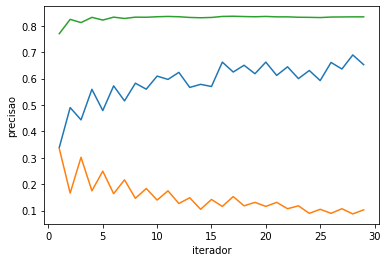

In [12]:
sns.lineplot(x = 'iterador', y = 'precisao', data = metrics_neigh)
sns.lineplot(x = 'iterador', y = 'recall', data = metrics_neigh)
sns.lineplot(x = 'iterador', y = 'acc', data = metrics_neigh)

In [13]:
metrics_neigh[metrics_neigh['recall'] == metrics_neigh['recall'].max()]

,precisao,recall,acc,iterador
0,0.339246,0.334792,0.770229,1


In [14]:
sm = SMOTE(random_state = 42, n_jobs = -1, sampling_strategy = 'all', k_neighbors = 1)

In [15]:
X_res, y_res = sm.fit_resample(X_train, y_train)

In [16]:
y_res.value_counts()

0    8648
1    8648
Name: revendeu_prox_mes, dtype: int64

In [ ]:
for i in modelos_lineares:
    print(f'Rodando o modelo {i[0]}')
    var = rodar_modelos(modelo = i, 
                       steps = steps_modelos_lineares, 
                       X_train = X_res, 
                       y_train = y_res, 
                       X_test = X_test,
                       y_test = y_test,
                       random_state = 42,
                       n_splits = 5,
                       n_jobs = -1)
    
    df_resultados.loc[i[0]] = var

for i in modelos_arvores:
    print(f'Rodando o modelo {i[0]}')
    var = rodar_modelos(modelo = i,
                       steps =  steps_modelos_arvores,
                       X_train = X_res, 
                       y_train = y_res, 
                       X_test = X_test,
                       y_test = y_test,
                       random_state = 42,
                       n_splits = 5,
                       n_jobs = -1)
    
    df_resultados.loc[i[0]] = var

In [ ]:
df_resultados.sort_values(by = 'roc_auc_test', ascending = False)

# Apply Best Model and hipertunning model

## Hipertunning

In [ ]:
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state = random_state)

In [ ]:
best_models = [Pipeline([("lgt",LGBMClassifier(random_state=42))]),
               Pipeline([("rf",RandomForestClassifier(random_state=42))]),
               Pipeline([("catboost",CatBoostClassifier(random_state=42))])
               
               
               ]

In [ ]:
parametros_lgt = {
   'lgt__max_depth': [3, 5, 7, 9, 12],
    'lgt__learning_rate': [0.02, 0.01, 0.03],
    'lgt__n_estimators': [1600, 1300, 1400],
}

parametros_rf = {
    'rf__max_depth': [3, 5, 7, 9, 12],
    'rf__max_leaf_nodes': [0, 1, 5],
    'rf__max_features': [None, "sqrt", "log2"],
    'rf__criterion':["gini", "entropy", "log_loss"]
}

parametros_catboost = {
    'catboost__depth': [2, 4, 6, 8],
    'catboost__learning_rate': [0.02, 0.01, 0.03],
    'catboost__n_estimators': [1600, 1300, 1400],
}

lista_parametros = [parametros_lgt, parametros_rf, parametros_catboost]


In [ ]:
for i, j in zip(best_models, lista_parametros):
    grid_search = GridSearchCV(i, j, scoring = 'roc_auc', cv = skf, n_jobs = -1, verbose = 1)
    grid_search.fit(X_res, y_res)
    print(grid_search.best_params_)

## LGT

In [ ]:
lgt = Pipeline(steps = [
    ('lgt', LGBMClassifier(learning_rate = 0.03,
                           random_state = 42, 
                           n_jobs = -1,
                           max_depth= 12,
                           n_estimators = 1600,
                           scale_pos_weight = 1
                           ))
]
)

lgt.fit(X_res, y_res)
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state = random_state)
cv_results = cross_validate(estimator = lgt, X = X_res, y = y_res, scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv = skf, n_jobs=-1)

In [ ]:
df_results_best_model = pd.DataFrame(cv_results).mean()
df_results_best_model

In [ ]:
y_pred = lgt.predict(X_test)
y_pred_prob = lgt.predict_proba(X_test)[:,1]

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'RoC-AUC: {roc_auc:.4f}')

In [ ]:
print(f'O recall é {recall_score(y_test, y_pred)}')
print(f'A precisão é {precision_score(y_test, y_pred)}')
print(f'A Acc é {accuracy_score(y_test, y_pred)}')

## RF

In [ ]:
rf = Pipeline(steps = [
    ('rf', RandomForestClassifier(max_depth = 12,
                           random_state = 42, 
                           n_jobs = -1,
                           criterion = 'gini',
                           max_features = 'sqrt',
                           max_leaf_nodes = 18
                           ))
]
)

rf.fit(X_res, y_res)
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state = random_state)
cv_results = cross_validate(estimator = rf, X = X_res, y = y_res, scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv = skf, n_jobs=-1)

In [ ]:
df_results_best_model = pd.DataFrame(cv_results).mean()
df_results_best_model

In [ ]:
y_pred = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)[:,1]

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'RoC-AUC: {roc_auc:.4f}')

In [ ]:
print(f'O recall é {recall_score(y_test, y_pred)}')
print(f'A precisão é {precision_score(y_test, y_pred)}')
print(f'A Acc é {accuracy_score(y_test, y_pred)}')

## CAT

In [18]:
catboost = Pipeline(steps = [
    ('catboost', CatBoostClassifier(depth = 8,
                           random_state = 42, 
                           learning_rate = 0.03,
                           n_estimators = 1600
                           ))
]
)

catboost.fit(X_res, y_res)
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42)
cv_results = cross_validate(estimator = catboost, X = X_res, y = y_res, scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv = skf, n_jobs=-1)

0:	learn: 0.6808804	total: 15.7ms	remaining: 25.1s
1:	learn: 0.6722769	total: 26.8ms	remaining: 21.4s
2:	learn: 0.6617844	total: 41.6ms	remaining: 22.1s
3:	learn: 0.6537693	total: 57.2ms	remaining: 22.8s
4:	learn: 0.6445111	total: 72.5ms	remaining: 23.1s
5:	learn: 0.6362091	total: 88ms	remaining: 23.4s
6:	learn: 0.6286134	total: 104ms	remaining: 23.6s
7:	learn: 0.6201848	total: 118ms	remaining: 23.5s
8:	learn: 0.6131772	total: 134ms	remaining: 23.6s
9:	learn: 0.6077557	total: 150ms	remaining: 23.8s
10:	learn: 0.6024023	total: 171ms	remaining: 24.7s
11:	learn: 0.5974947	total: 212ms	remaining: 28.1s
12:	learn: 0.5915660	total: 308ms	remaining: 37.6s
13:	learn: 0.5877838	total: 329ms	remaining: 37.2s
14:	learn: 0.5826347	total: 351ms	remaining: 37s
15:	learn: 0.5786374	total: 393ms	remaining: 38.9s
16:	learn: 0.5750918	total: 434ms	remaining: 40.4s
17:	learn: 0.5714173	total: 469ms	remaining: 41.2s
18:	learn: 0.5673311	total: 498ms	remaining: 41.5s
19:	learn: 0.5623546	total: 552ms	remai

In [19]:
df_results_best_model = pd.DataFrame(cv_results).mean()
df_results_best_model

fit_time          54.162904
score_time         0.058356
test_accuracy      0.889627
test_precision     0.902273
test_recall        0.873961
test_f1            0.887846
test_roc_auc       0.948579
dtype: float64

In [22]:
y_pred = catboost.predict(X_test)
y_pred_prob = catboost.predict_proba(X_test)[:,1]

In [23]:
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'RoC-AUC: {roc_auc:.4f}')

RoC-AUC: 0.7910


In [24]:
print(f'O recall é {recall_score(y_test, y_pred)}')
print(f'A precisão é {precision_score(y_test, y_pred)}')
print(f'A Acc é {accuracy_score(y_test, y_pred)}')

O recall é 0.4573304157549234
A precisão é 0.5529100529100529
A Acc é 0.8408396946564886


Text(0.5, 1.0, 'Feature Importance')

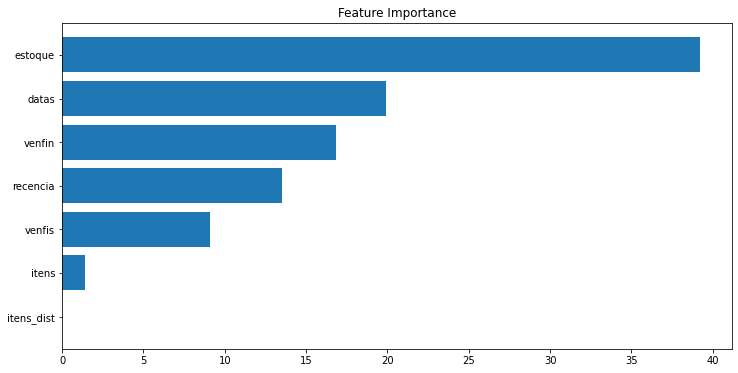

In [28]:
feature_importance = catboost[-1].feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')


In [29]:
feature_importance

array([ 9.09733168, 16.82055097,  1.42297269,  0.        , 19.91537265,
       39.20652684, 13.53724517])

In [ ]:
!pip install shap==0.39.0

In [ ]:
import shap
explainer = shap.TreeExplainer(catboost[-1])

In [ ]:
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values, X_test)